In [2]:
import numpy as np
from torchvision.datasets import CelebA
import matplotlib.pyplot as plt
import cv2
from PIL import Image


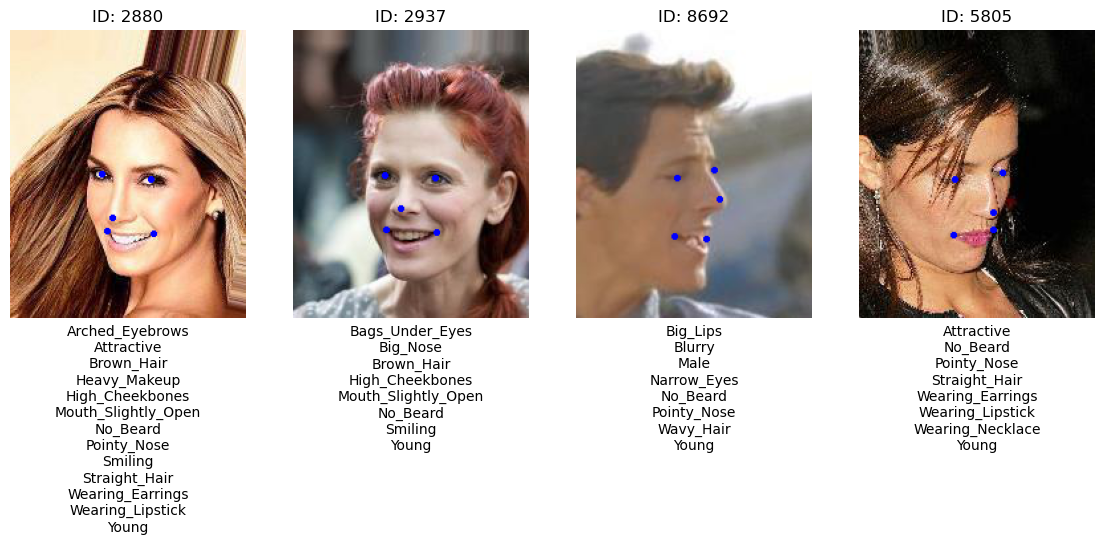

../datasets\celeba\img_celeba\000001.jpg
../datasets\celeba\img_celeba\000002.jpg
../datasets\celeba\img_celeba\000003.jpg
../datasets\celeba\img_celeba\000004.jpg


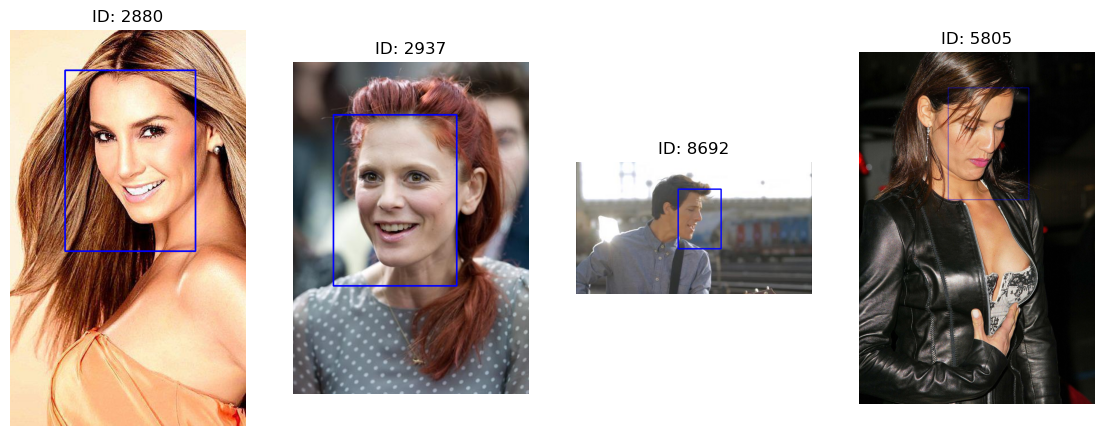

In [24]:
root_dir = '../datasets'
celeba = CelebA(root=root_dir, split='train',
                target_type=['attr', 'identity', 'bbox', 'landmarks'],
                download=False)
attr_names = celeba.attr_names
attr_names.pop()
attr_names = np.array(attr_names)    
fig = plt.figure(figsize=(14, 7))

n = 4 # 显示的图片数量
for idx in range(n):
    img, (attr, identity, bbox, landmarks) = celeba[idx]  # 读取图片和相关标签值
    ax = fig.add_subplot(1, 4, idx + 1)
    # 不显示刻度标签和边框
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(b=False)

    # 将CelebA数据集读取到的PIL图片格式转换成OprnCV所需格式
    img_cv2 = cv2.cvtColor(src=np.asanyarray(img), code=cv2.COLOR_RGB2BGR)

    # 绘制特征点
    landmarks = landmarks.numpy()
    for idx, point in enumerate(landmarks):
        if idx % 2 == 0:
            cv2.circle(img=img_cv2, center=(point, landmarks[idx + 1]),
                        radius=1, color=(255, 0, 0), thickness=2)
    attr_list = attr.numpy()
    attrs = attr_names[attr_list==1]
    label = ''     
    # 属性标签
    for att in attrs:
        label = label + att + '\n'
    ax.set_xlabel(label)
    # 身份ID
    cele_id = identity.numpy()
    ax.set_title(f'ID: {cele_id}')
    # 将OpenCV图片再次转成成Pillow图片格式
    img_pil = Image.fromarray( cv2.cvtColor(src=img_cv2,
                                            code=cv2.COLOR_BGR2RGB,))
    ax.imshow(img_pil)
plt.show()

# 显示标注框
fig = plt.figure(figsize=(14, 7))
for idx in range(n):
    img, (attr, identity, bbox, landmarks) = celeba[idx]
    ax = fig.add_subplot(1, 4, idx + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(b=False)
    
    # 图片的读取改为使用原图像
    file_path = os.path.join(celeba.root, celeba.base_folder, 'img_celeba', celeba.filename[idx])

    img_cv2 = cv2.imread(file_path)
    bbox = bbox.numpy()
    cv2.rectangle(img=img_cv2, pt1=(bbox[0], bbox[1]),
                  pt2=(bbox[0] + bbox[2], bbox[1] + bbox[3]),
                  color=(255, 0, 0), thickness=2)
    cele_id = identity.numpy()
    ax.set_title(f'ID: {cele_id}')
    img_pil = Image.fromarray(cv2.cvtColor(src=img_cv2,
                                           code=cv2.COLOR_BGR2RGB,))
    ax.imshow(img_pil)
plt.show()

In [5]:
import cv2
import numpy as np

def generate_crop_boxes(cx, cy, w, h):
    """
    根据给定的人脸中心点坐标和尺寸,生成5个候选的裁剪框。
    
    参数:
    cx (float): 人脸中心点的 x 坐标
    cy (float): 人脸中心点的 y 坐标
    w (int): 人脸框的宽度
    h (int): 人脸框的高度
    
    返回:
    crop_boxes (list): 一个包含5个裁剪框坐标的列表,每个裁剪框的格式为 [x1, y1, x2, y2]
    """
    crop_boxes = []
    for _ in range(5):
        # 生成随机的偏移量,限制在人脸框宽高的20%范围内
        w_offset = np.random.uniform(max(-w * 0.2, -w), min(w * 0.2, w))
        h_offset = np.random.uniform(max(-h * 0.2, -h), min(h * 0.2, h))
        
        # 计算新的中心点坐标,并限制在图像边界内
        cx_ = np.clip(cx + w_offset, 0, 1024)
        cy_ = np.clip(cy + h_offset, 0, 768)
        
        # 随机生成边长,范围为原人脸框宽高的80%到125%
        side_len = np.random.uniform(min(w, h) * 0.8, max(w, h) * 1.25)
        side_len = round(side_len)
        
        # 计算裁剪框的坐标,确保在图像边界内
        x1_ = np.max([cx_ - side_len // 2, 0])
        y1_ = np.max([cy_ - side_len // 2, 0])
        x2_ = np.min([x1_ + side_len, 1024])
        y2_ = np.min([y1_ + side_len, 768])
        
        # 添加裁剪框坐标到列表中
        crop_boxes.append(np.array([x1_, y1_, x2_, y2_]))
    
    return crop_boxes


# 读取图像信息字符串
image_info = "000001.jpg 95 71 226 313"

# 解析图像信息
parts = image_info.split()
image_path = parts[0]
x1, y1, width, height = [int(x) for x in parts[1:]]

# 计算人脸中心点坐标和尺寸
cx = x1 + width / 2
cy = y1 + height / 2
w = width
h = height

# 读取图像
img = cv2.imread('image.jpg')

# 生成裁剪框
crop_boxes = generate_crop_boxes(cx, cy, w, h)

# 在图像上绘制裁剪框
for box in crop_boxes:
    x1, y1, x2, y2 = [int(v) for v in box]
    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)  # 绘制蓝色裁剪框

# 在图像上绘制原人脸区域
cv2.rectangle(img, (int(x1), int(y1)), (int(x1 + width), int(y1 + height)), (0, 0, 255), 2)  # 绘制红色人脸框

# 在图像上绘制人脸中心点
cv2.circle(img, (int(cx), int(cy)), 5, (0, 0, 255), -1)  # 绘制红色人脸中心点

# 显示结果
cv2.imshow('Crop Boxes', img)
cv2.waitKey(0)
cv2.destroyAllWindows()